Notebook based on https://keras.io/guides/transfer_learning/

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

### Load the dataset
To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [ ]:

import ipywidgets




In [ ]:
tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True )

In [ ]:
print("Number of training samples:  ", tf.data.experimental.cardinality(train_ds))
print("Number of validation samples:", tf.data.experimental.cardinality(validation_ds))
print("Number of test samples:      ", tf.data.experimental.cardinality(test_ds))

Number of training samples:   tf.Tensor(9305, shape=(), dtype=int64)
Number of validation samples: tf.Tensor(2326, shape=(), dtype=int64)
Number of test samples:       tf.Tensor(2326, shape=(), dtype=int64)


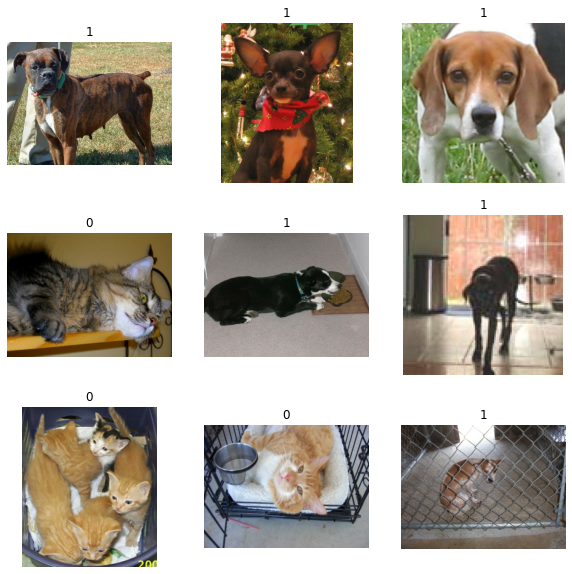

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3,i+1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

### Standardizing the data

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

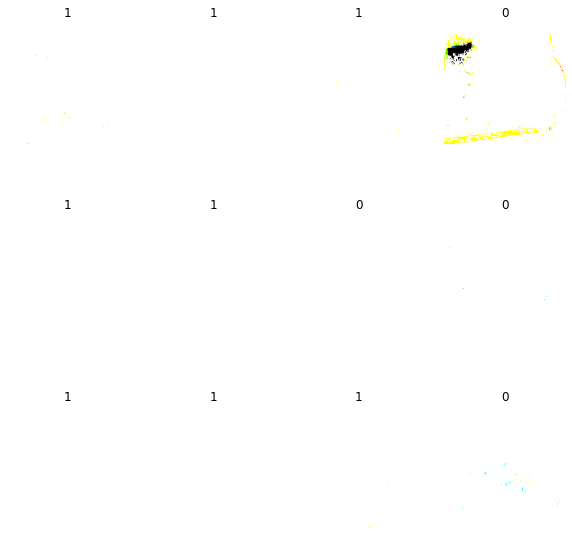

In [ ]:
plt.figure(figsize=(10,10))
for i,(images,labels) in enumerate(train_ds.take(12)):
    ax = plt.subplot(3,4,i+1)
    ax.imshow(images)
    plt.title(int(labels))
    ax.axis('off')

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [ ]:
batch_size = 32

train_ds      = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds       = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the first image of the first batch looks like after various random transformations:

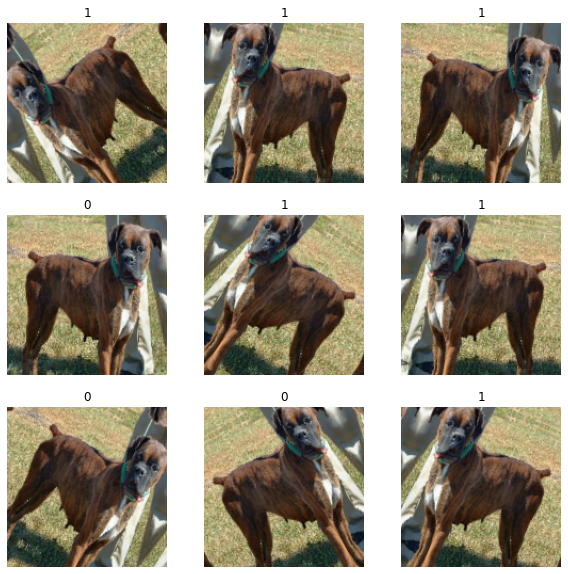

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Build a model

### Get pre-trained model (Xception)

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

### Freeze the base model.

In [ ]:
base_model.trainable = False

### Create "head"
Output: 1 unit (binary classification)

In [ ]:
inp = keras.Input(shape=(150, 150, 3))
x = base_model(inp, training=False)       # Skeleton (frozen at begining)
x = keras.layers.GlobalAveragePooling2D()(x) # Reshape for head
out = keras.layers.Dense(1)(x)               # Head (unfrozen)

model = keras.Model(inp, out)

### Train the model on new data (Transfer learning)

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss      = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics   = [keras.metrics.BinaryAccuracy()])

model.fit(train_ds,
          epochs          = 20,
          validation_data = validation_ds
          #callbacks      = ...
)

Epoch 1/20
133/291 [============>.................] - ETA: 6:42 - loss: 2.3874 - binary_accuracy: 0.5636

KeyboardInterrupt: 

### Unfreeze and Do a round of fine-tuning of the entire model


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10


KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=24a806f2-ea86-4de0-a8d4-b27a68052882' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>